# Problem

Using quantum circuits to simulate a quantum system is one of the original purposes of quantum computing. Please describe how to construct a quantum circuit to simulate a physical system evolution in Hamiltonian:
$$
\hat{H}=\sum_{k=1}^{N-1}J_k(\sigma^x_k\sigma^x_{k+1}+\sigma^y_k\sigma^y_{k+1}), \quad J_k=\sqrt{k(N-k)}
$$
For $t=\pi/2$, where the initial state is $\ket{\psi(t=0)}=\ket{10\cdots0}_N$

# Primitive analysis

The time evolution operator corresponding to this Hamiltonian is
$$
e^{i\frac{\hat{H}}\hbar t} = \exp(i\frac t \hbar \sum_{k=1}^{N-1}J_k(\sigma^x_k\sigma^x_{k+1}+\sigma^y_k\sigma^y_{k+1}))
$$
In this Hamiltonian, $\sigma^x_k$ and $\sigma^y_k$ don't commute with each other. Therefore, we need to use the Trotter-Suzuki decomposition formula
$$
\begin{aligned}
e^{i\frac{\hat{H}}\hbar t}\approx& \left[\exp(i\frac t {n\hbar} \sum_{k=1}^{N-1}J_k\sigma^x_k\sigma^x_{k+1})\cdot \exp(i\frac t {n\hbar} \sum_{k=1}^{N-1}J_k\sigma^y_k\sigma^y_{k+1})\right]^n\\
=&\left[\prod^{N-1}_{k=1}\exp(i\theta_k\sigma^x_k\sigma^x_{k+1})\cdot \prod^{N-1}_{k=1}\exp(i\theta_k\sigma^y_k\sigma^y_{k+1})\right]^n
\end{aligned}
$$
where $\theta_k={J_kt}/{n\hbar}$. 

The equation above suggest that the evolution is equivlent to $n$ layers of $k$ $XX$ and $YY$ rotations with angles of $\theta_k$.

In natural units, $\hbar=1$.

# Define the time-evolution as a function

In [91]:
from qiskit import QuantumCircuit, Aer
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.quantum_info.operators import Operator
import numpy as np
from scipy.constants import hbar
import matplotlib.pyplot as plt

In [92]:
def time_evo(N, t, n, fig_plot=False, prob=False): # symbols are exactly the same as above
    """
    calcuate the time evolution following the Hamiltonian above
    Args:
        N: int, number of qubits
        t: float, the total time of evolution
        n: int, number of layers
        fig_plot: bol, plot the circuit or not

    Returns:
        epct_vle: the expected value of the final result (decimal, in computational base)
    """
    qc = QuantumCircuit(N)
    qc.x(N-1) # initial state

    # build layers
    for i in range(n): 
        for k in range(N-1):
            theta = np.sqrt((k+1)*(N-k-1))*t/n # python feature
            qc.ryy(2*theta, k, k+1)
            qc.rxx(2*theta, k, k+1)

    # plot the circuit
    if fig_plot == True:
        display(qc.draw('mpl'))

    if prob == True:
        prob_moment = []
        for i in range(N):
            z_ops = Operator.from_label(i*'I'+'Z'+(N-1-i)*'I') # computational basis
            prob_moment.append((1-Statevector(qc).expectation_value(z_ops))/2)
        return prob_moment

    # calculate the expected value
    epct_vle = 0
    sv = Statevector(qc).to_dict()
    for key, value in sv.items():
        epct_vle += int(key, 2) * np.abs(value)**2
    return epct_vle

# Demonstration: single layer

The circuit of a single layer evolution is shown below

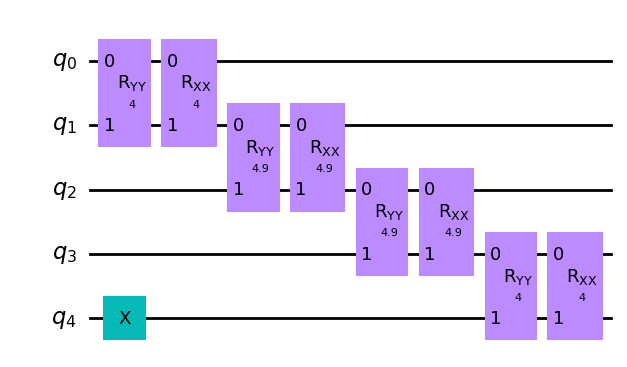

In [93]:
val = time_evo(5, 1, 1, fig_plot=True)

# Demonstration: time-evolution

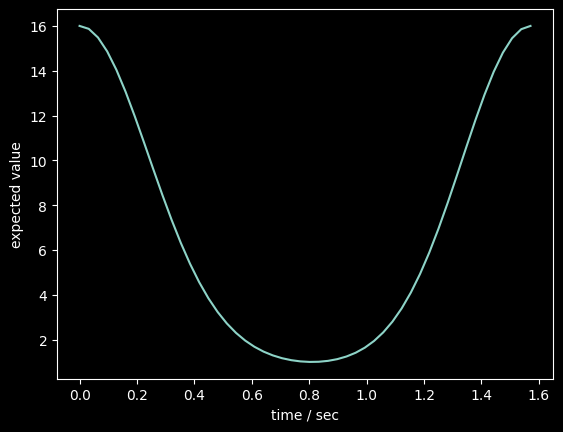

In [94]:
val = []
time = np.linspace(0, np.pi/2, 50)
for t in time:
    val.append(time_evo(5, t, 50, fig_plot=False))

plt.plot(time, val)
plt.xlabel("time / sec")
plt.ylabel("expected value")
plt.show()

# Demonstration: accuracy with the number of layers

The reference (epct_vle=16) is calculated by Julia.

Please find the reference results in `Julia_evolution.ipynb`.

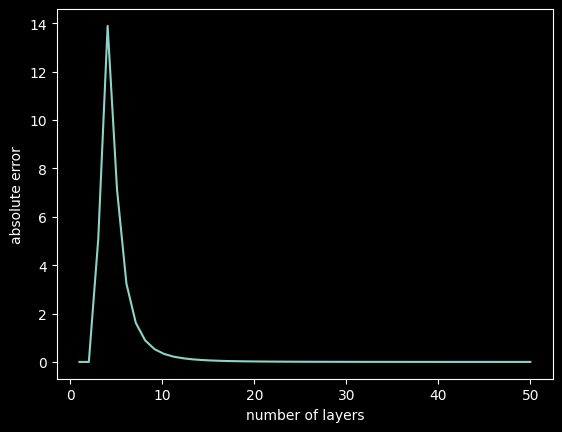

In [95]:
val = []
max_layer = 50
xx = np.linspace(1, max_layer, max_layer-1)
for n in range(1, max_layer):
    val.append(time_evo(5, np.pi/2, n, fig_plot=False))
error = abs(val - np.ones(max_layer-1)*16) # calculate the absolute error
plt.plot(xx, error)
plt.xlabel("number of layers")
plt.ylabel('absolute error')
plt.show()

# Demontration: trace the probabilities

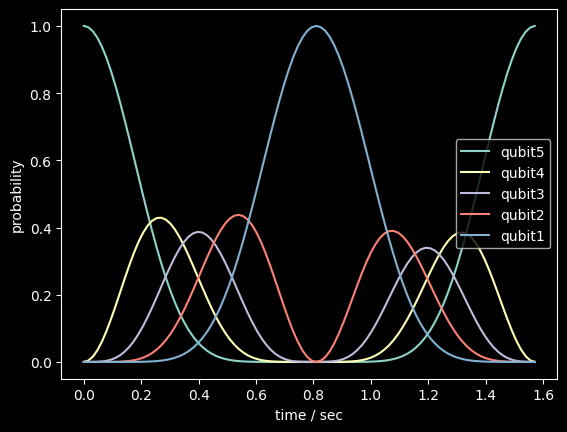

In [96]:
prob_trace = []
time = np.linspace(0, np.pi/2, 100)
for t in time:
    prob_trace.append(time_evo(5, t, 50, fig_plot=False, prob=True))
plt.plot(time, prob_trace)
plt.xlabel("time / sec")
plt.ylabel("probability")
plt.legend(["qubit5", "qubit4", "qubit3", "qubit2", "qubit1"], loc=5)
plt.show()